Submission with voting with rf and xgboost

In [1]:
import json
import pandas as pd
import os
import numpy as np

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')

In [2]:
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))
        print(f"Successfully loaded {len(train_data)} battles.")
    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        # To keep the output clean, we can create a copy and truncate the timeline
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
        
        # Use json.dumps for pretty-printing the dictionary
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

In [3]:
test_data = []

print(f"Loading data from '{test_file_path}'...")
try:
    with open(test_file_path, 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
    
    print("\n--- Structure of the first test battle: ---")
    if test_data:
            first_test_battle = test_data[0]
            
            # To keep the output clean, we can create a copy and truncate the timeline
            test_battle_for_display = first_test_battle.copy()
            test_battle_for_display['battle_timeline'] = test_battle_for_display.get('battle_timeline', [])[:5] # Show first 2 turns
            
            # Use json.dumps for pretty-printing the dictionary
            print(json.dumps(test_battle_for_display, indent=4))
            if len(first_test_battle.get('battle_timeline', [])) > 3:
                print("    ...")
                print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{test_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/test.jsonl'...

--- Structure of the first test battle: ---
{
    "p1_team_details": [
        {
            "name": "gengar",
            "level": 100,
            "types": [
                "ghost",
                "poison"
            ],
            "base_hp": 60,
            "base_atk": 65,
            "base_def": 60,
            "base_spa": 130,
            "base_spd": 130,
            "base_spe": 110
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",
                "notype"
            ],
            "base_hp": 250,
            "base_atk": 5,
            "base_def": 5,
            "base_spa": 105,
            "base_spd": 105,
            "base_spe": 50
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 

Codice per creare nuove variabili:
- Percentuale di turni in cui il pokemon del player presenta uno status (1 per giocatore)
- Numero totale di boosts ricevuti (1 per ogni giocatore)
- Numero di turni "null" (1 per giocatore)
- Media accuracy (1 per giocatore)
- Numero di volte in cui un giocatore attacca (1 per giocatore)
- Somma della priority (1 per giocatore)

In [4]:

types = [
    "bug", "dark", "dragon", "electric", "fairy", "fighting", "fire", "flying",
    "ghost", "grass", "ground", "ice", "normal", "poison", "psychic", "rock",
    "steel", "stellar", "water"
]

# Matrice delle efficacie (valori numerici)
# x2 = 2.0, x½ = 0.5, x0 = 0.0, x1 = 1.0
# Ogni riga corrisponde al tipo attaccante, ogni colonna al tipo difensore
type_chart = np.array([
#  Bu  Da  Dr  El  Fa  Fi  Fi  Fl  Gh  Gr  Gr  Ic  No  Po  Ps  Ro  St  St  Wa
  [1,  2,  1,  1,  1,  0.5,0.5,0.5,1,  2,  1,  1,  1,  0.5,2,  1,  0.5,1,  1],  # Bug
  [1,  0.5,1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1],  # Dark
  [1,  1,  2,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0.5,1,  1],  # Dragon
  [1,  1,  0.5,0.5,1,  1,  1,  2,  1,  0.5,0,  1,  1,  1,  1,  1,  1,  1,  2],  # Electric
  [1,  2,  2,  1,  1,  0.5,0.5,1,  1,  1,  1,  1,  1,  0.5,1,  1,  0.5,1,  1],  # Fairy
  [0.5,2,  1,  1,  0.5,1,  1,  0,  1,  1,  1,  2,  1,  0.5,2,  2,  1,  1,  1],  # Fighting
  [0.5,1,  0.5,1,  1,  1,  0.5,1,  1,  2,  1,  2,  1,  1,  1,  0.5,0.5,1,  0.5],# Fire
  [2,  1,  1,  0.5,1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  0.5,0.5,1,  1],  # Flying
  [1,  0.5,1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  0,  1,  2,  1,  1,  1,  1],  # Ghost
  [0.5,1,  1,  1,  1,  1,  0.5,0.5,1,  0.5,2,  1,  1,  0.5,1,  2,  0.5,1,  0.5],# Grass
  [0.5,1,  1,  2,  1,  1,  2,  0,  1,  0.5,1,  2,  1,  2,  1,  2,  1,  1,  1],  # Ground
  [1,  1,  2,  1,  1,  1,  0.5,2,  1,  2,  1,  0.5,1,  1,  1,  1,  0.5,1,  0.5],# Ice
  [1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  0.5,0.5,1,  1],  # Normal
  [1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  0.5, 1,  1,  0.5,1,  0.5,0,  1,  1], # Poison
  [1,  2,  1,  1,  1,  0.5,1,  1,  1,  1,  1,  1,  1,  1,  0.5, 1,  0.5,1,  1], # Psychic
  [2,  1,  1,  1,  1,  0.5,2,  2,  1,  1,  0.5, 2,  1,  1,  1,  1,  0.5,1,  1], # Rock
  [1,  1,  0.5,0.5,1,  1,  2,  1,  1,  1,  2,  2,  1,  1,  1,  2,  0.5,1,  0.5],# Steel
  [1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],  # Stellar
  [1,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  0.5,1,  1,  1,  2,  1,  1,  0.5] # Water
])

# Converti in DataFrame per etichette leggibili
type_chart_df = pd.DataFrame(type_chart, index=types, columns=types)


In [12]:
count_level = 0
pokemon_not_level_100 = []
for battle in train_data:
    squad = battle.get("p1_team_details")
    for pokemon in squad:
        level = pokemon.get("level")
        if level != 100:
            #print(pokemon.get("name"), pokemon.get("level"))
            count_level += 1
            pokemon_not_level_100.append(pokemon)
print(count_level)
#print(pokemon_not_level_100)

13


In [11]:
used_pokemon = set()
count = 0
for battle in train_data:
    battle_timeline = battle.get('battle_timeline', [])
    for i in battle_timeline:
        nome_p1 = i.get("p1_pokemon_state").get("name")
        nome_p2 = i.get("p2_pokemon_state").get("name")
        if nome_p1 not in used_pokemon:
            used_pokemon.add(nome_p1)
            count += 1
        if nome_p2 not in used_pokemon:
            used_pokemon.add(nome_p2)
            count += 1

print(count)

20


In [10]:
pokedex = {}

for battle in train_data:
    squad = battle.get("p1_team_details")
    for pokemon in squad:
        nome = pokemon.get("name")
        if nome not in pokedex:
            pokedex[nome] = pokemon
    pokemon_p2 = battle.get("p2_lead_details").get("name")
    if pokemon_p2 not in pokedex:
        pokedex[pokemon_p2] = battle.get("p2_lead_details")

print(len(pokedex))
print(json.dumps(pokedex, indent=4))

20
{
    "starmie": {
        "name": "starmie",
        "level": 100,
        "types": [
            "psychic",
            "water"
        ],
        "base_hp": 60,
        "base_atk": 75,
        "base_def": 85,
        "base_spa": 100,
        "base_spd": 100,
        "base_spe": 115
    },
    "exeggutor": {
        "name": "exeggutor",
        "level": 100,
        "types": [
            "grass",
            "psychic"
        ],
        "base_hp": 95,
        "base_atk": 95,
        "base_def": 85,
        "base_spa": 125,
        "base_spd": 125,
        "base_spe": 55
    },
    "chansey": {
        "name": "chansey",
        "level": 100,
        "types": [
            "normal",
            "notype"
        ],
        "base_hp": 250,
        "base_atk": 5,
        "base_def": 5,
        "base_spa": 105,
        "base_spd": 105,
        "base_spe": 50
    },
    "snorlax": {
        "name": "snorlax",
        "level": 100,
        "types": [
            "normal",
            "n

In [65]:
from tqdm.notebook import tqdm
import numpy as np

def create_simple_features(data: list[dict]) -> pd.DataFrame:
    """
    A very basic feature extraction function.
    It only uses the aggregated base stats of the player's team and opponent's lead.
    """
    feature_list = []
    for battle in tqdm(data, desc="Extracting features"):
        features = {}
        
        # --- Player 1 Team Features ---
        p1_team = battle.get('p1_team_details', [])
        if p1_team:
            features['p1_mean_hp'] = np.mean([p.get('base_hp', 0) for p in p1_team])
            features['p1_mean_spe'] = np.mean([p.get('base_spe', 0) for p in p1_team])
            features['p1_mean_atk'] = np.mean([p.get('base_atk', 0) for p in p1_team])
            features['p1_mean_def'] = np.mean([p.get('base_def', 0) for p in p1_team])
            features['p1_mean_spa'] = np.mean([p.get('base_spa', 0) for p in p1_team])
            features['p1_mean_spd'] = np.mean([p.get('base_spd', 0) for p in p1_team])

        # --- Player 2 Lead Features ---
        #p2_lead = battle.get('p2_lead_details')
        #if p2_lead:
            # Player 2's lead Pokémon's stats
            #features['p2_lead_hp'] = p2_lead.get('base_hp', 0)
            #features['p2_lead_spe'] = p2_lead.get('base_spe', 0)
            #features['p2_lead_atk'] = p2_lead.get('base_atk', 0)
            #features['p2_lead_def'] = p2_lead.get('base_def', 0)
            #features['p2_lead_spa'] = p2_lead.get('base_spa', 0)
            #features['p2_lead_spd'] = p2_lead.get('base_spd', 0)

        battle_timeline = battle.get('battle_timeline', [])
        p2_team = {}
        for i in battle_timeline:
            name_p2 = i.get("p2_pokemon_state", {}).get("name")
            if name_p2:
                p2_team[name_p2] = pokedex.get(name_p2, {})
        features['p2_mean_hp'] = np.mean([p2_team[p].get('base_hp', 0) for p in p2_team])
        features['p2_mean_spe'] = np.mean([p2_team[p].get('base_spe', 0) for p in p2_team])
        features['p2_mean_atk'] = np.mean([p2_team[p].get('base_atk', 0) for p in p2_team])
        features['p2_mean_def'] = np.mean([p2_team[p].get('base_def', 0) for p in p2_team])
        features['p2_mean_spa'] = np.mean([p2_team[p].get('base_spa', 0) for p in p2_team])
        features['p2_mean_spd'] = np.mean([p2_team[p].get('base_spd', 0) for p in p2_team])

        # --- Players Status pokemon ---
        
        #if battle_timeline:
        status_p1=0
        status_p2=0
        for i in battle_timeline:
            if i.get('p1_pokemon_state').get("status")!= 'nostatus':
                status_p1+=1
            if i.get('p2_pokemon_state').get("status")!= 'nostatus':
                status_p2+=1
        status_p1= status_p1/len(battle_timeline)
        features['p1_status'] =  round(status_p1,3)
        status_p2= status_p2/len(battle_timeline)
        features['p2_status'] =  round(status_p2,3)

                # --- Players Boosts ---
                
        boosts_p1 = 0
        boosts_p2 = 0
        
        for i in battle_timeline:
            boosts1 = i.get('p1_pokemon_state').get("boosts")
            boosts2 = i.get('p2_pokemon_state').get("boosts")
        
            for j in boosts1:
                boosts_p1 += boosts1.get(j)
            for k in boosts2:
                boosts_p2 += boosts2.get(k)
        
        
        #features["boosts_p1"] = boosts_p1
        #features["boosts_p2"] = boosts_p2
        features["diff_boost"] = boosts_p1 - boosts_p2
        
                # --- Players' move "null" ---
        null_1=0
        null_2=0
        for i in battle_timeline:
            if not i.get('p1_move_details'):
                null_1 += 1
            if not i.get('p2_move_details'):
                null_2 += 1
        
        features['null_p1'] = null_1
        features['null_p2'] = null_2

                # --- Players' accuracy ---
        acc_1 = 0
        n_acc1 = 0
        acc_2 = 0
        n_acc2 = 0
        for i in battle_timeline:
            if i.get('p1_move_details'):
                acc_1 += float(i.get('p1_move_details').get('accuracy'))
                n_acc1 += 1
            if i.get('p2_move_details'):
                acc_2 += float(i.get('p2_move_details').get('accuracy'))
                n_acc2 += 1
        '''if n_acc1 != 0:
            features['avg_acc_p1'] = acc_1/n_acc1
        else:
            features['avg_acc_p1'] = 0
        if n_acc2 != 0:
            features['avg_acc_p2'] = acc_2/n_acc2
        else:
            features['avg_acc_p2'] = 0
                
        features["diff_avg_acc"] = features['avg_acc_p1'] - features['avg_acc_p2']'''

        if n_acc1 != 0:
            avg_acc1 = acc_1/n_acc1
        else:
            avg_acc1 = 0
        if n_acc2 != 0:
            avg_acc2 = acc_2/n_acc2
        else:
            avg_acc2 = 0

        features["diff_avg_acc"] = avg_acc1 - avg_acc2

        
        # numero di volte in cui attacca

        diz_p1 = {}
        count_p2 = 0
        for i in battle_timeline:
            nome = i.get('p1_pokemon_state').get('name')
            hp = i.get('p1_pokemon_state').get('hp_pct')
            if nome not in diz_p1:
                if int(hp) != 1:
                    diz_p1[nome] = hp
                    count_p2 += 1
                else:
                    diz_p1[nome] = hp
            else:
                if diz_p1[nome] > hp:
                    diz_p1[nome] = hp
                    count_p2 += 1
                else:
                    diz_p1[nome] = hp
        diz_p2 = {}
        count_p1 = 0
        for i in battle_timeline:
            nome = i.get('p2_pokemon_state').get('name')
            hp = i.get('p2_pokemon_state').get('hp_pct')
            if nome not in diz_p2:
                if int(hp) != 1:
                    diz_p2[nome] = hp
                    count_p1 += 1
                else:
                    diz_p2[nome] = hp
            else:
                if diz_p2[nome] > hp:
                    diz_p2[nome] = hp
                    count_p1 += 1
                else:
                    diz_p2[nome] = hp

        features['n_atk_p1'] = count_p1
        features['n_atk_p2'] = count_p2

        
        # Diff damage inflicted

        diz_1 = {}
        def_p1 = 0
        diz_2 = {}
        atk_p1 = 0
        for i in battle_timeline:
            # somma difesa p1
            diff_p1 = 0
            nome_1 = i.get("p1_pokemon_state").get("name")
            hp_1 = i.get("p1_pokemon_state").get("hp_pct")
            if nome_1 not in diz_1:
                if int(hp_1) != 1:
                    diff_p1 = 1 - hp_1
                    diz_1[nome_1] = hp_1
                else:
                    diz_1[nome_1] = hp_1
            else:
                diff_p1 = diz_1[nome_1] - hp_1
                diz_1[nome_1] = hp_1
            def_p1 += diff_p1 
            
        for i in battle_timeline:
            # somma attacco p1 (o difesa p2)
            diff_p2 = 0
            nome_2 = i.get("p2_pokemon_state").get("name")
            hp_2 = i.get("p2_pokemon_state").get("hp_pct")   
            if nome_2 not in diz_2:
                if int(hp_2) != 1:
                    diff_p2 = 1 - hp_2
                    diz_2[nome_2] = hp_2
                else:
                    diz_2[nome_2] = hp_2
            else:
                diff_p2 = diz_2[nome_2] - hp_2
                diz_2[nome_2] = hp_2
            atk_p1 += diff_p2
        
        features["diff_damage"] = atk_p1 - def_p1
        
        # Count priority
        
        priority_1 = 0
        for i in battle_timeline:
            if i.get('p1_move_details'):
                priority = i.get('p1_move_details').get('priority')
                priority_1 += priority

        priority_2 = 0
        for i in battle_timeline:
            if i.get('p2_move_details'):
                priority = i.get('p2_move_details').get('priority')
                priority_2 += priority
        features["priority_1"] = priority_1
        features["priority_2"] = priority_2
        #features["diff_priority"] = priority_1 - priority_2


             # --- Players' offensive effectivness ---

        '''types_p1 = {}
        p1_team = battle.get('p1_team_details')
        for p in p1_team:
            types_p1[p.get('name')] = p.get('types')
        
        
        count_1 = 0
        for i in battle_timeline:
            molt = 1
            if i.get('p2_move_details') and i.get('p2_move_details').get('category') != "STATUS":
                move = i.get('p2_move_details').get('type').lower()
                name_p1 = i.get('p1_pokemon_state').get('name')
                for j in types_p1[name_p1]:
                    if j == "notype":
                        pass
                    else:
                        if move != "notype":
                            molt *= type_chart_df.loc[move,j]
                if molt > 1:
                    count_1 += 1
        features["oe_p2"] = count_1

        types_p2 = {}
        count_2 = 0
        for i in battle_timeline:
            name_p2 = i.get("p2_pokemon_state").get("name")
            if name_p2 not in types_p2:
                types_p2[name_p2] = pokedex[name_p2].get("types")

        for i in battle_timeline:
            molt = 1
            if i.get('p1_move_details') and i.get('p1_move_details').get('category') != "STATUS":
                move = i.get('p1_move_details').get('type').lower()
                name_p2 = i.get('p2_pokemon_state').get('name')
                for j in types_p2[name_p2]:
                    if j == "notype":
                        pass
                    else:
                        if move != "notype":
                            molt *= type_chart_df.loc[move,j]
                if molt > 1:
                    count_2 += 1
        features["oe_p1"] = count_2'''

        #features["diff_oe"] = count_1 - count_2
                

                # --- Players' KO ---

        count_p1 = 0
        count_p2 = 0
        for i in battle_timeline:
            if i.get('p1_pokemon_state').get('status') == 'fnt':
                count_p1 += 1
            if i.get('p2_pokemon_state').get('status') == 'fnt':
                count_p2 += 1
        features['ko_p1'] = count_p1
        features['ko_p2'] = count_p2
        #features["diff_ko"] = count_p1 - count_p2


                # --- Number of special attacks ---
        
        count_p1 = 0
        sp_atk_1 = 0
        count_p2 = 0
        sp_def_1 = 0
        for i in battle_timeline:
            if i.get("p1_move_details"):
                nome_p1 = i.get("p1_pokemon_state").get("name")
                if i.get('p1_move_details').get('category') == 'SPECIAL':
                    count_p1 += 1
                    sp_atk_1 += next(p.get('base_spa', 0) for p in p1_team if p.get("name") == nome_p1)
            if i.get("p2_move_details"):
                if i.get('p2_move_details').get('category') == 'SPECIAL':
                    count_p2 += 1
        features['n_sp_atk_1'] = count_p1
        features['n_sp_atk_2'] = count_p2
        #features["diff_sp_atk"] = count_p1 - count_p2
        '''if count_p1 != 0:
            features["avg_sp_atk_1"] = sp_atk_1 / count_p1
        else:
            features["avg_sp_atk_1"] = 0
        features["sp_atk_1"] = sp_atk_1'''
        
        # numero volte in cui attacca con blizard / ice beam
        count_move_p1_frz = 0
        count_move_p2_frz = 0

        for i in battle_timeline:
            if i.get("p1_move_details"):
                move = i.get("p1_move_details").get("name")
                if move == "blizzard" or move == "icebeam":
                    count_move_p1_frz += 1
            
            if i.get("p2_move_details"):
                move = i.get("p2_move_details").get("name")
                if move == "blizzard" or move == "icebeam":
                    count_move_p2_frz += 1

        # numero volte in cui attacca con thunderwave

        
        count_move_p1_spe = 0
        count_move_p2_spe = 0

        for i in battle_timeline:
            if i.get("p1_move_details"):
                move = i.get("p1_move_details").get("name")
                if move == "thunderwave":
                    count_move_p1_spe += 1
            
            if i.get("p2_move_details"):
                move = i.get("p2_move_details").get("name")
                if move == "thunderwave":
                    count_move_p2_spe += 1

        features["move_p1_blic"] = count_move_p1_frz
        features["move_p2_blic"] = count_move_p2_frz
        features["move_p1_tw"] = count_move_p1_spe
        features["move_p2_tw"] = count_move_p1_spe


        #features["null_p1 x ko_p1"] = features["null_p1"]*features["ko_p1"]
        #features["n_atk_p2 x ko_p1"] = features["n_atk_p2"]*features["ko_p1"]
        #features["p2_status x null_p2"] = features["p2_status"]*features["null_p2"]
        features["p2_status x null_p2"] = features["p2_status"]*null_2
        features["p2_status x null_p2^2"] = features["p2_status"]*null_2**2
        features["p1_status x null_p1"] = features["p1_status"]*null_1
        features["p1_status x null_p1^2"] = features["p1_status"]*null_1**2
        features["p2_mean_hp x p2_mean_atk"] = features["p2_mean_hp"]*features["p2_mean_atk"]
        features["p2_mean_hp x p2_mean_def"] = features["p2_mean_hp"]*features["p2_mean_def"]

        
        #features["null_p1 x n_atk_p2"] = features["null_p1"]*features["n_atk_p2"]

        
        #features["p2_lead_spe x n_atk_p2 x ko_p1"] = features["p2_lead_spe"]*features["n_atk_p2"]*features["ko_p1"]
        #features["p2_lead_spe x p2_status x null_p2"] = features["p2_lead_spe"]*features["p2_status"]*features["null_p2"]
        #features["p2_lead_spe x null_p1 x n_atk_p2"] = features["p2_lead_spe"]*features["null_p1"]*features["n_atk_p2"]
        #features["p2_lead_spe x null_p1 x ko_p1"] = features["p2_lead_spe"]*features["null_p1"]*features["ko_p1"]
        #features["p2_lead_atk x null_p2"] = features["p2_lead_atk"]*features["null_p2"]
        #features["p2_lead_atk x null_p1 x ko_p1"] = features["p2_lead_atk"]*features["null_p1"]*features["ko_p1"]
        #features["p2_lead_atk x n_atk_p2 x ko_p1"] = features["p2_lead_atk"]*features["n_atk_p2"]*features["ko_p1"]
        #features["p2_lead_def x null_p2"] = features["p2_lead_def"]*features["null_p2"]
        #features["p2_lead_def x n_atk_p2 x ko_p1"] = features["p2_lead_def"]*features["n_atk_p2"]*features["ko_p1"]
        #features["p2_lead_def x null_p2 x p2_status"] = features["p2_lead_def"]*features["null_p2"]*features["p2_status"]
        #features["p1_status x null_p1"] = features["p1_status"]*features["null_p1"]
        #features["p1_status x null_p1 x ko_p1"] = features["p1_status"]*features["null_p1"]*features["ko_p1"]
        #features["p1_status x n_atk_p2 x ko_p1"] = features["p1_status"]*features["n_atk_p2"]*features["ko_p1"]
        #features["p1_status x null_p1 x n_atk_p2"] = features["p1_status"]*features["null_p1"]*features["n_atk_p2"]
        #features["n_atk_p2 x null_p1 x ko_p1"] = features["n_atk_p2"]*features["null_p1"]*features["ko_p1"]
        #features["oe_p1 x null_p2 x p2_status"] = features["oe_p1"]*features["null_p2"]*features["p2_status"]


            
        # We also need the ID and the target variable (if it exists)
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
            
        feature_list.append(features)
        
    return pd.DataFrame(feature_list).fillna(0)

# Create feature DataFrames for both training and test sets
#print("Processing training data...")
train_df = create_simple_features(train_data)

#print("\nProcessing test data...")

test_df = create_simple_features(test_data)

#print("\nTraining features preview:")
display(train_df.head(5))
display(train_df.tail(5))

train_df.describe()

Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]

,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p1_tw,move_p2_tw,p2_status x null_p2,p2_status x null_p2^2,p1_status x null_p1,p1_status x null_p1^2,p2_mean_hp x p2_mean_atk,p2_mean_hp x p2_mean_def,battle_id,player_won
0,115.833333,80.000000,72.500000,63.333333,100.000000,100.000000,141.250000,62.5,71.25,60.000000,...,1,1,7.938,111.132,0.699,2.097,10064.062500,8475.000000,0,1
1,123.333333,61.666667,72.500000,65.833333,90.000000,90.000000,115.833333,80.0,72.50,63.333333,...,1,1,1.169,8.183,2.569,17.983,8397.916667,7336.111111,1,1
2,124.166667,65.833333,84.166667,71.666667,90.000000,90.000000,110.000000,97.5,55.00,51.250000,...,1,1,3.736,29.888,1.500,4.500,6050.000000,5637.500000,2,1
3,121.666667,75.833333,77.500000,65.833333,103.333333,103.333333,101.250000,77.5,101.25,77.500000,...,0,0,0.835,4.175,4.669,32.683,10251.562500,7846.875000,3,1
4,114.166667,72.500000,75.833333,79.166667,97.500000,97.500000,128.000000,72.0,77.00,67.000000,...,3,3,2.932,11.728,1.200,4.800,9856.000000,8576.000000,4,1


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p1_tw,move_p2_tw,p2_status x null_p2,p2_status x null_p2^2,p1_status x null_p1,p1_status x null_p1^2,p2_mean_hp x p2_mean_atk,p2_mean_hp x p2_mean_def,battle_id,player_won
9995,124.166667,66.666667,85.833333,75.833333,85.000000,85.000000,121.666667,76.666667,79.166667,70.000000,...,0,0,1.000,5.000,5.400,48.600,9631.944444,8516.666667,9995,0
9996,115.000000,65.833333,74.166667,75.000000,102.500000,102.500000,97.500000,75.000000,100.000000,89.166667,...,5,5,2.802,16.812,1.732,6.928,9750.000000,8693.750000,9996,0
9997,111.666667,79.166667,78.333333,72.500000,100.833333,100.833333,126.000000,64.000000,81.000000,80.000000,...,1,1,1.500,7.500,3.798,22.788,10206.000000,10080.000000,9997,0
9998,124.166667,66.666667,85.833333,75.833333,85.000000,85.000000,114.000000,86.000000,73.000000,71.000000,...,0,0,0.165,0.825,3.665,18.325,8322.000000,8094.000000,9998,0
9999,85.833333,93.333333,80.833333,66.666667,91.666667,91.666667,90.000000,82.000000,81.000000,65.000000,...,1,1,1.998,11.988,2.165,10.825,7290.000000,5850.000000,9999,0


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p1_tw,move_p2_tw,p2_status x null_p2,p2_status x null_p2^2,p1_status x null_p1,p1_status x null_p1^2,p2_mean_hp x p2_mean_atk,p2_mean_hp x p2_mean_def,battle_id,player_won
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,113.124317,75.772917,77.711017,70.703667,95.409750,95.409750,115.342813,74.341042,76.207305,68.806440,...,2.287900,2.287900,2.504236,20.616109,2.855163,23.424750,8705.622946,7797.536740,4999.50000,0.500000
std,13.405444,8.116724,7.118607,9.887678,7.121009,7.121009,18.785770,10.322285,9.544791,12.113323,...,2.064907,2.064907,1.892661,27.620079,2.027865,30.576133,1360.013094,1210.364331,2886.89568,0.500025
min,63.333333,46.666667,55.833333,48.333333,73.333333,73.333333,55.000000,30.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,1250.000000,0.00000,0.000000
25%,109.166667,69.166667,72.500000,63.333333,90.833333,90.833333,105.000000,67.500000,70.833333,61.250000,...,1.000000,1.000000,1.165000,5.328000,1.468000,6.400000,7878.000000,7039.583333,2499.75000,0.000000
50%,116.666667,75.833333,75.833333,69.166667,96.666667,96.666667,120.000000,74.000000,75.000000,67.000000,...,2.000000,2.000000,2.100000,11.417000,2.400000,12.800000,8820.833333,7728.000000,4999.50000,0.500000
75%,121.666667,80.000000,81.666667,75.833333,100.000000,100.000000,127.500000,80.000000,82.500000,75.833333,...,3.000000,3.000000,3.335000,24.300000,3.731000,26.973000,9565.277778,8530.555556,7499.25000,1.000000
max,135.833333,110.833333,110.666667,112.500000,121.666667,121.666667,250.000000,130.000000,134.000000,132.500000,...,17.000000,17.000000,20.010000,600.300000,20.000000,500.000000,17600.000000,13875.000000,9999.00000,1.000000


In [66]:
from sklearn.linear_model import LogisticRegression

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
y_train = train_df['player_won']

X_test = test_df[features]

# Initialize and train the model
#print("Training a simple Logistic Regression model...")

#fit1 = model.fit(X_train, y_train)
#print("Model training complete.")

In [ ]:
'''import matplotlib.pyplot as plt
from itertools import combinations

for f1, f2 in combinations(features[13:], 2):
    plt.figure()
    plt.scatter(X_train[f1]*X_train[f2], y_train + np.random.uniform(-0.5, 0.5, size=len(y_train)), c = y_train, cmap='bwr', alpha=0.7)
    plt.xlabel(f"{f1} x {f2}")
    plt.ylabel("player_won")
    plt.title(f'Scatterplot: {f1} x {f2}')
    plt.grid(True)
    plt.show()'''

**Scaling**

In [67]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)



X_train_scaled_df = pd.DataFrame(X_train_scaled, columns= features )
X_train_scaled_df.head()
X_train_scaled_df.describe()

,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p1_blic,move_p2_blic,move_p1_tw,move_p2_tw,p2_status x null_p2,p2_status x null_p2^2,p1_status x null_p1,p1_status x null_p1^2,p2_mean_hp x p2_mean_atk,p2_mean_hp x p2_mean_def
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-4.170886e-16,-9.535484e-16,7.389644e-17,-1.131184e-15,-3.353762e-16,-3.353762e-16,4.554579e-16,-2.316369e-16,-5.570655e-16,-7.673862e-16,...,-1.136868e-17,-5.684342e-17,-5.542233e-17,-5.542233e-17,-1.818989e-16,-9.094947e-17,2.728484e-16,-4.547474e-17,3.410605e-16,-1.239187e-15
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.714422e+00,-3.586140e+00,-3.073463e+00,-2.262559e+00,-3.100336e+00,-3.100336e+00,-3.212316e+00,-4.295876e+00,-7.460704e+00,-5.267723e+00,...,-9.456987e-01,-9.414468e-01,-1.108047e+00,-1.108047e+00,-1.323196e+00,-7.464548e-01,-1.408036e+00,-7.661505e-01,-5.482297e+00,-5.409829e+00
25%,-2.952418e-01,-8.139467e-01,-7.320642e-01,-7.454431e-01,-6.426962e-01,-6.426962e-01,-5.505939e-01,-6.627780e-01,-5.630548e-01,-6.238435e-01,...,-9.456987e-01,-9.414468e-01,-6.237397e-01,-6.237397e-01,-7.076295e-01,-5.535420e-01,-6.840854e-01,-5.568265e-01,-6.085709e-01,-6.262505e-01
50%,2.642603e-01,7.443852e-03,-2.637844e-01,-1.554538e-01,1.765170e-01,1.765170e-01,2.479227e-01,-3.304101e-02,-1.264947e-01,-1.491358e-01,...,-3.231394e-01,-3.280665e-01,-1.394322e-01,-1.394322e-01,-2.135915e-01,-3.330754e-01,-2.244657e-01,-3.475024e-01,8.471694e-02,-5.745395e-02
75%,6.372618e-01,5.208129e-01,5.557053e-01,5.188198e-01,6.446389e-01,6.446389e-01,6.471811e-01,5.482547e-01,6.593135e-01,5.801252e-01,...,6.106995e-01,5.920040e-01,3.448754e-01,3.448754e-01,4.389615e-01,1.333839e-01,4.319226e-01,1.160522e-01,6.321247e-01,6.056486e-01
max,1.694099e+00,4.319744e+00,4.629740e+00,4.227324e+00,3.687431e+00,3.687431e+00,7.168400e+00,5.392386e+00,6.055196e+00,5.258404e+00,...,5.279894e+00,5.192356e+00,7.125182e+00,7.125182e+00,9.249747e+00,2.098882e+01,8.455048e+00,1.558729e+01,6.540247e+00,5.021436e+00


In [68]:
from scipy import stats
from itertools import combinations

corr = []
for f1, f2 in combinations(features, 2):
        x1 = X_train_scaled_df[f1]
        x2 = X_train_scaled_df[f2]
        prod = x1 * x2
        r, p = stats.pointbiserialr(y_train, prod)
        corr.append([r, f1, f2])

# Creo il DataFrame
corr_df = pd.DataFrame(corr, columns=["correlation", "feature_1", "feature_2"])

# Sort per valore assoluto della correlazione
corr_df = corr_df.reindex(corr_df["correlation"].abs().sort_values(ascending=False).index)

# Print delle prime 20 (o tutte)
print(corr_df.head(20))

     correlation            feature_1              feature_2
453    -0.154163              null_p1  p1_status x null_p1^2
452    -0.152621              null_p1    p1_status x null_p1
660    -0.138274  p1_status x null_p1  p1_status x null_p1^2
470     0.123742              null_p2    p2_status x null_p2
471     0.119374              null_p2  p2_status x null_p2^2
651     0.107643  p2_status x null_p2  p2_status x null_p2^2
202     0.106159           p2_mean_hp            p2_mean_atk
203     0.102434           p2_mean_hp            p2_mean_def
510     0.101325             n_atk_p1  p1_status x null_p1^2
608     0.100960           n_sp_atk_1  p1_status x null_p1^2
260    -0.099268          p2_mean_atk            p2_mean_def
201     0.087363           p2_mean_hp            p2_mean_spe
525    -0.079084             n_atk_p2  p2_status x null_p2^2
315    -0.078646          p2_mean_spa            p2_mean_spd
437     0.077557              null_p1               n_atk_p1
616    -0.076310        

**Grid Search**

In [69]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report)

model = LogisticRegression(random_state=42, max_iter=1000)

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Create the GridSearchCV object
grid_logreg = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=4,        # use 4 cores in parallel
    cv=5,            # 5-fold cross-validation, more on this later
    refit='roc_auc',      # retrain the best model on the full training set
    return_train_score=True
)

# Fit the GridSearchCV object on the training data
grid_logreg.fit(X_train_scaled, y_train)

# Read the cv_results_ property into a DataFrame
cv_results_df = pd.DataFrame(grid_logreg.cv_results_)

# Check what type of object the best_estimator_ property returns
print(type(grid_logreg.best_estimator_))

# Use the best estimator to make predictions on the test set
predictions_lr = grid_logreg.best_estimator_.predict(X_test_scaled)

# Display a few predicted class labels (0 = benign, 1 = malignant)
print("Predicted labels:", predictions_lr[:10])

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Predicted labels: [0 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py",

In [71]:
best_score = grid_logreg.best_score_
print("Best ROC_AUC score:", best_score) # output: the biggest AUC w.r.t. mean_test_score 


cv_df = pd.DataFrame(grid_logreg.cv_results_)
best_idx = grid_logreg.best_index_
mean_acc = cv_df.loc[best_idx, 'mean_test_accuracy']
print("\naccuracy",mean_acc) 

mean_auc = cv_df.loc[best_idx, 'mean_test_roc_auc']
print("\nauc",mean_auc) 

best_params = grid_logreg.best_params_
print("\nBest hyperparameters:\n",best_params) # ouput: hyperparameters used in the best model

# Estrai il modello migliore
best_log_reg = grid_logreg.best_estimator_

# Coefficienti del modello (per una regressione logistica)

coef = best_log_reg.coef_.flatten()

feature_names = X_train.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': abs(coef)
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

# auc = 0.901
# acc = 0.8301
# {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best ROC_AUC score: 0.9022804000000001

accuracy 0.8311

auc 0.9022804000000001

Best hyperparameters:
 {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
                     Feature  Coefficient
20               diff_damage     1.984579
6                 p2_mean_hp     0.737904
31       p2_status x null_p2     0.710908
32     p2_status x null_p2^2     0.591448
35  p2_mean_hp x p2_mean_atk     0.502451
9                p2_mean_def     0.341063
33       p1_status x null_p1     0.338071
36  p2_mean_hp x p2_mean_def     0.318730
16                   null_p2     0.288517
7                p2_mean_spe     0.284593
18                  n_atk_p1     0.263368
34     p1_status x null_p1^2     0.200790
12                 p1_status     0.192385
1                p1_mean_spe     0.167626
8                p2_mean_atk     0.166245
21                priority_1     0.155535
19                  n_atk_p2     0.130763
0                 p1_mean_hp     0.129490
17              diff_avg_acc     0.113711
15   

**Change of treshold in the Logistic Regression**

In [24]:
# Cross-validation finale per ottenere OOF probabilities con i best params

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_prob_oof = np.zeros_like(y_train, dtype=float)
y_true_oof = np.array(y_train)  # copia allineata

for tr_idx, va_idx in skf.split(X_train_scaled, y_train):
    X_tr, X_va = X_train_scaled[tr_idx], X_train_scaled[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]

    clf = LogisticRegression(**best_params, random_state=42, max_iter=1000)
    clf.fit(X_tr, y_tr)
    y_prob_oof[va_idx] = clf.predict_proba(X_va)[:, 1]

# Soglia che massimizza l'accuracy sulle OOF (nessun leakage)
thresholds = np.linspace(0.0, 1.0, 1001)
accs = [accuracy_score(y_true_oof, (y_prob_oof >= t).astype(int)) for t in thresholds]
t_star = thresholds[int(np.argmax(accs))]
acc_oof = np.max(accs)

print(f"Soglia ottimale (OOF): {t_star}")
print(f"Accuracy OOF massima: {acc_oof}")

# Fit finale su tutto il training con i best params

final_clf = LogisticRegression(**best_params, random_state=42, max_iter=1000)
final_clf.fit(X_train_scaled, y_train)

y_prob_test = final_clf.predict_proba(X_test_scaled)[:, 1]
predictions_lr_t_star  = (y_prob_test >= t_star).astype(int)

Soglia ottimale (OOF): 0.556
Accuracy OOF massima: 0.8296


**PCA for Logistic Regression**

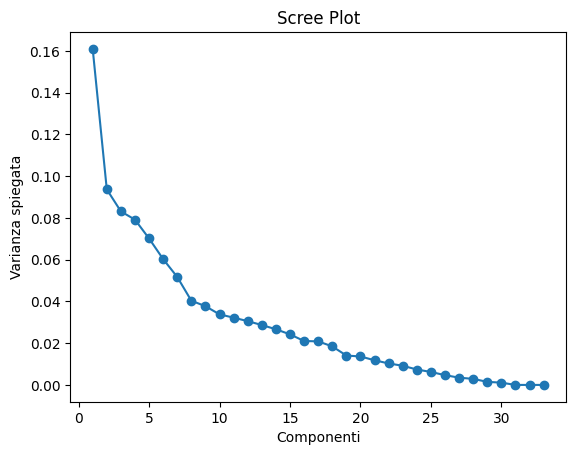

Best k: 26
[0.16098019 0.25467054 0.33781152 0.41698844 0.48714136 0.54742278
 0.59913854 0.63947877 0.6772087  0.71101309 0.74324073 0.77379319
 0.80249547 0.82916092 0.85339492 0.87443697 0.89530131 0.91376938
 0.92785069 0.94148099 0.95330232 0.96358861 0.97277549 0.98016211
 0.9863729  0.99105603 0.99453307 0.99743921 0.99891044 1.
 1.         1.         1.        ]


In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pca = PCA().fit(X_train_scaled)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', best_log_reg)
])

plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.xlabel("Componenti")
plt.ylabel("Varianza spiegata")
plt.title("Scree Plot")
plt.show()

param_grid = {
    'pca__n_components': [8,10, 15, 19, 20, 22, 24, 26]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train_scaled, y_train)

print(np.cumsum(pca.explained_variance_ratio_))
print("Best k: 18")

**PCA for KNN**

In [38]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'pca__n_components': [3, 6, 9, 12, 15, 18, 21],
    'knn__n_neighbors': [9, 12, 15, 18, 21, 24, 27, 30]
}

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

print("Best params KNN:", grid_knn.best_params_)
print("Best AUC KNN:", grid_knn.best_score_)
cv_knn = pd.DataFrame(grid_knn.cv_results_)
cv_knn = cv_knn[['param_pca__n_components', 'param_knn__n_neighbors',
                 'mean_test_score', 'std_test_score']]
print(cv_knn.sort_values(['mean_test_score']))
print("Best k = 9\n Best number of components = 18")

Best params KNN: {'knn__n_neighbors': 30, 'pca__n_components': 21}
Best AUC KNN: 0.8701302000000002
   param_pca__n_components param_knn__n_neighbors  mean_test_score  \
0                        3                      9         0.824087   
7                        3                     12         0.830984   
14                       3                     15         0.835463   
21                       3                     18         0.836900   
28                       3                     21         0.839258   
35                       3                     24         0.840482   
42                       3                     27         0.841444   
49                       3                     30         0.842253   
1                        6                      9         0.843320   
2                        9                      9         0.843782   
3                       12                      9         0.845528   
4                       15                      9         0.

In [45]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=18)),
    ('clf', best_log_reg)
])
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=18)),
    ('knn', KNeighborsClassifier(n_neighbors = 9))
])

voting = VotingClassifier(
    estimators=[
        ("lr_pca", pipe_lr),
        ("knn_pca", pipe_knn),
        ("rf", rf_clf),
        ("xgb", xgb_clf)
    ],
    voting='soft'
)
voting_acc = cross_val_score(voting, X_train_scaled, y_train, cv = 5).mean()
print(voting_acc)

0.8307


**KNN**

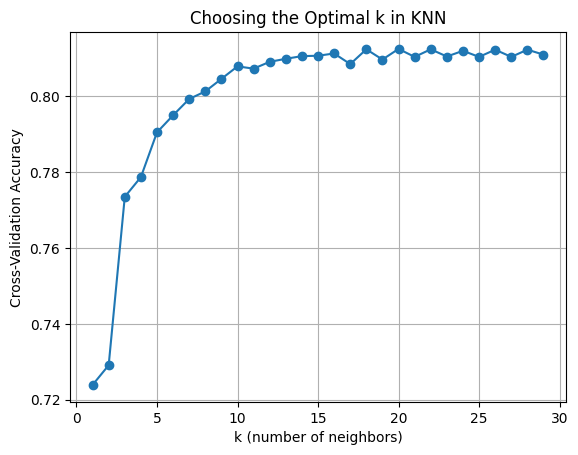

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ks = range(1, 30)
# Compute 5-fold cross-validation accuracy for each k
scores = [
    cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train_scaled, y_train, cv=5).mean()
    for k in ks
]
plt.plot(ks, scores, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing the Optimal k in KNN')
plt.grid(True)
plt.show()

#elbow at k = 18

In [68]:
acc_knn = cross_val_score(KNeighborsClassifier(n_neighbors = 18), X_train_scaled, y_train, cv = 5).mean()
print(acc_knn)

0.8123999999999999


**Decision tree**

In [55]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

'''full_tree = DecisionTreeClassifier(random_state=42)
full_tree.fit(X_train_scaled, y_train)

# Compute effective alphas and impurities for pruning
path = full_tree.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Evaluate performance for each alpha using cross-validation
acc_scores = []
for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    score = cross_val_score(pruned_tree, X_train_scaled, y_train, cv=5).mean()
    acc_scores.append(score)

# Plot cross-validation accuracy vs alpha
plt.figure(figsize=(6, 4))
plt.plot(ccp_alphas, acc_scores, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Cost Complexity Pruning")
plt.grid(True)
plt.show()'''

'full_tree = DecisionTreeClassifier(random_state=42)\nfull_tree.fit(X_train_scaled, y_train)\n\n# Compute effective alphas and impurities for pruning\npath = full_tree.cost_complexity_pruning_path(X_train_scaled, y_train)\nccp_alphas, impurities = path.ccp_alphas, path.impurities\n\n# Evaluate performance for each alpha using cross-validation\nacc_scores = []\nfor ccp_alpha in ccp_alphas:\n    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)\n    score = cross_val_score(pruned_tree, X_train_scaled, y_train, cv=5).mean()\n    acc_scores.append(score)\n\n# Plot cross-validation accuracy vs alpha\nplt.figure(figsize=(6, 4))\nplt.plot(ccp_alphas, acc_scores, marker=\'o\', drawstyle="steps-post")\nplt.xlabel("ccp_alpha")\nplt.ylabel("Cross-Validation Accuracy")\nplt.title("Cost Complexity Pruning")\nplt.grid(True)\nplt.show()'

In [ ]:
'''best_alpha = ccp_alphas[np.argmax(acc_scores)]
print(f"Optimal alpha: {best_alpha:.5f}")
best_tree = DecisionTreeClassifier(criterion = "gini", random_state = 42, ccp_alpha = best_alpha)
tree_acc = cross_val_score(best_tree, X_train_scaled, y_train, cv = 5).mean()
print(tree_acc)'''

**XGboost, ADABoost**

In [ ]:
pip install xgboost -q

In [22]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [69]:
from xgboost import XGBClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),  # weak learner (stump)
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
acc_ada = cross_val_score(ada_clf, X_train_scaled, y_train, cv =5).mean()


xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
acc_xgb = cross_val_score(xgb_clf, X_train_scaled, y_train, cv =5).mean()
print(acc_ada,"\n", acc_xgb )

'''0.8269 
 0.8235999999999999'''

0.8281000000000001 
 0.8263


'0.8269 \n 0.8235999999999999'

**Random forest, Bagging**

In [70]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
acc_rf = cross_val_score(rf_clf, X_train_scaled, y_train, cv = 5).mean()

print(acc_rf)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=100,       # number of trees
    max_samples=0.8,        # each tree sees 80% of training data
    bootstrap=True,         # sample with replacement
    random_state=42
)
acc_bag = cross_val_score(bag_clf, X_train_scaled, y_train, cv = 5).mean()

print(acc_bag)

'''0.8254999999999999
0.8256'''

0.8300999999999998
0.8251


'0.8254999999999999\n0.8256'

**Ensamble (Voting)**

In [71]:
log_clf = best_log_reg
knn_clf = KNeighborsClassifier(n_neighbors = 18)

# voting con random forest
voting_rf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rf_clf),
        ('knn', knn_clf)
    ],
    voting='soft'  # --> average predicted probabilities
)
voting_acc_rf = cross_val_score(voting_rf, X_train_scaled, y_train, cv = 5).mean()


# voting con ada_boost
voting_ada = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('ada', ada_clf),
        ('knn', knn_clf)
    ],
    voting='soft'  # --> average predicted probabilities
)
voting_acc_ada = cross_val_score(voting_ada, X_train_scaled, y_train, cv = 5).mean()

# voting con xgboost
voting_xgb = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('xgb', xgb_clf),
        ('knn', knn_clf)
    ],
    voting='soft'  # --> average predicted probabilities
)
voting_acc_xgb = cross_val_score(voting_xgb, X_train_scaled, y_train, cv = 5).mean()

# voting con xgboost e rf
voting_xgb_rf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('xgb', xgb_clf),
        ('knn', knn_clf),
        ('rf', rf_clf)
    ],
    voting='soft'  # --> average predicted probabilities
)
voting_acc_xgb_rf = cross_val_score(voting_xgb_rf, X_train_scaled, y_train, cv = 5).mean()
voting_xgb_rf.fit(X_train, y_train)
predictions_vot_xgb_rf = voting_xgb_rf.predict(X_test)



print(f"accuracy con random forest {voting_acc_rf}")
print(f"accuracy con ada_boost {voting_acc_ada}")
print(f"accuracy con xgboost {voting_acc_xgb}")
print(f"accuracy con xgboost e rf {voting_acc_xgb_rf}")

accuracy con random forest 0.8286999999999999
accuracy con ada_boost 0.8263999999999999
accuracy con xgboost 0.8336
accuracy con xgboost e rf 0.8352999999999999


**model stacking**

In [26]:
from sklearn.ensemble import StackingClassifier

# con random forest

models = [
    ("lr", log_clf),
    ("rf", rf_clf),
    ("knn", knn_clf)
]

meta_learner = LogisticRegression(random_state = 42, max_iter = 1000)
stacking_rf = StackingClassifier(
    estimators=models,
    final_estimator=meta_learner,
    cv=5  # cross-validation for base model predictions
)

In [27]:
'''param_grid = {
    'final_estimator__C': [0.1, 1, 1.5, 2],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

grid_rf = GridSearchCV(stacking_rf, param_grid, scoring = ["roc_auc", "accuracy"], refit = "roc_auc",n_jobs = 4 , cv=5)
grid_rf.fit(X_train_scaled, y_train)
predictions_stack_rf = grid_rf.best_estimator_.predict(X_test_scaled)


rf_results_df = pd.DataFrame(grid_rf.cv_results_)
best_idx = grid_rf.best_index_
acc_stacking_rf = rf_results_df.loc[best_idx, 'mean_test_accuracy']'''

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 276, in fit
    _fit_single_es

In [28]:
# con ada_boost

models = [
    ("lr", log_clf),
    ("ada", ada_clf),
    ("knn", knn_clf)
]

meta_learner = LogisticRegression(random_state = 42, max_iter = 1000) # o best_log_reg?

stacking_ada = StackingClassifier(
    estimators=models,
    final_estimator=meta_learner,
    cv=5  # cross-validation for base model predictions
)

#acc_stacking_ada = cross_val_score(stacking_ada, X_train_scaled, y_train, cv = 5).mean()


In [29]:
'''param_grid = {
    'final_estimator__C': [0.1, 1, 1.5, 2],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

grid_ada = GridSearchCV(stacking_ada, param_grid, scoring = ["roc_auc", "accuracy"], refit = "roc_auc",n_jobs = 4 , cv=5)
grid_ada.fit(X_train_scaled, y_train)
predictions_stack_ada = grid_ada.best_estimator_.predict(X_test_scaled)


ada_results_df = pd.DataFrame(grid_ada.cv_results_)
best_idx = grid_ada.best_index_
acc_stacking_ada = ada_results_df.loc[best_idx, 'mean_test_accuracy']'''

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 276, in fit
    _fit_single_es

In [30]:
# con xgboost

models = [
    ("lr", log_clf),
    ("xgb", xgb_clf),
    ("knn", knn_clf)
]

meta_learner = LogisticRegression(random_state = 42, max_iter = 1000) # o best_log_reg?

stacking_xgb = StackingClassifier(
    estimators=models,
    final_estimator=meta_learner,
    cv=5  # cross-validation for base model predictions
)

#acc_stacking_xgb = cross_val_score(stacking_xgb, X_train_scaled, y_train, cv = 5).mean()


In [31]:
'''param_grid = {
    'final_estimator__C': [0.1, 1, 1.5, 2],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

grid_xgb = GridSearchCV(stacking_xgb, param_grid, scoring = ["roc_auc", "accuracy"], refit = "roc_auc",n_jobs = 4 , cv=5)
grid_xgb.fit(X_train_scaled, y_train)
predictions_stack_xgb = grid_xgb.best_estimator_.predict(X_test_scaled)


xgb_results_df = pd.DataFrame(grid_xgb.cv_results_)
best_idx = grid_xgb.best_index_
acc_stacking_xgb = xgb_results_df.loc[best_idx, 'mean_test_accuracy']'''

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 276, in fit
    _fit_single_es

In [72]:
# con xgboost e random forest

models = [
    ("lr", log_clf),
    ("xgb", xgb_clf),
    ("knn", knn_clf),
    ('rf', rf_clf)
]

meta_learner = LogisticRegression(random_state = 42, max_iter = 1000) # o best_log_reg?

stacking_xgb_rf = StackingClassifier(
    estimators=models,
    final_estimator=meta_learner,
    cv=5  # cross-validation for base model predictions
)

In [73]:
'''param_grid = {
    'final_estimator__C': [0.1, 1, 1.5, 2],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

grid_xgb_rf = GridSearchCV(stacking_xgb_rf, param_grid, scoring = ["roc_auc", "accuracy"], refit = "roc_auc",n_jobs = 4 , cv=5)
grid_xgb_rf.fit(X_train_scaled, y_train)
predictions_stack_xgb_rf = grid_xgb_rf.best_estimator_.predict(X_test_scaled)


xgb_rf_results_df = pd.DataFrame(grid_xgb_rf.cv_results_)
best_idx = grid_xgb_rf.best_index_
acc_stacking_xgb_rf = xgb_rf_results_df.loc[best_idx, 'mean_test_accuracy']'''

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 276, in fit
    _fit_single_es

In [74]:
#print(f"accuracy con rf {acc_stacking_rf}")
#print(f"accuracy con ada_boost {acc_stacking_ada}")
#print(f"accuracy con xgboost {acc_stacking_xgb}")
#print(f"accuracy con xgboost e rf {acc_stacking_xgb_rf}")

accuracy con xgboost e rf 0.8337


### 4. Creating the Submission File

The competition requires a `.csv` file with two columns: `battle_id` and `player_won`. Let's use our trained model to make predictions on the test set and format them correctly.

In [ ]:
# Make predictions on the test data
print("Generating predictions on the test set...")
#test_predictions = model.predict(X_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    #'player_won': test_predictions
    'player_won': predictions_vot_xgb_rf
})

# Save the DataFrame to a .csv file
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' file created successfully!")
display(submission_df.head())

### 5. Submitting Your Results

Once you have generated your `submission.csv` file, there are two primary ways to submit it to the competition.

---

#### Method A: Submitting Directly from the Notebook

This is the standard method for code competitions. It ensures that your submission is linked to the code that produced it, which is crucial for reproducibility.

1.  **Save Your Work:** Click the **"Save Version"** button in the top-right corner of the notebook editor.
2.  **Run the Notebook:** In the pop-up window, select **"Save & Run All (Commit)"** and then click the **"Save"** button. This will run your entire notebook from top to bottom and save the output, including your `submission.csv` file.
3.  **Go to the Viewer:** Once the save process is complete, navigate to the notebook viewer page. 
4.  **Submit to Competition:** In the viewer, find the **"Submit to Competition"** section. This is usually located in the header of the output section or in the vertical "..." menu on the right side of the page. Clicking the **Submit** button this will submit your generated `submission.csv` file.

After submitting, you will see your score in the **"Submit to Competition"** section or in the [Public Leaderboard](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025/leaderboard?).

---

#### Method B: Manual Upload

You can also generate your predictions and submission file using any environment you prefer (this notebook, Google Colab, or your local machine).

1.  **Generate the `submission.csv` file** using your model.
2.  **Download the file** to your computer.
3.  **Navigate to the [Leaderboard Page](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025/leaderboard?)** and click on the **"Submit Predictions"** button.
4.  **Upload Your File:** Drag and drop or select your `submission.csv` file to upload it.

This method is quick, but keep in mind that for the final evaluation, you might be required to provide the code that generated your submission.

Good luck!